<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2 : Modélisation** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allos:
* Résoudre le problème de désiquilibre entre les classes.
* Implémenter un modèle de machine learning
* Chercher les meilleurs hyperparamètres par gridsearchCV
* .....

# Importation des données et des librairies Python pour DS

In [80]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
from contextlib import contextmanager
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
import mlflow

In [2]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [3]:
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [5]:
train_df = pd.read_csv('data/traited/df_train_35.csv')

In [6]:
train_df.head()

,EXT_SOURCE_2,PREV_DAYS_DECISION_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,DAYS_REGISTRATION,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,BURO_DAYS_CREDIT_MAX,POS_MONTHS_BALANCE_MEAN,BURO_CREDIT_TYPE_Creditcard_MEAN,CLOSED_DAYS_CREDIT_MAX,BURO_STATUS_0_MEAN_MEAN,HOUR_APPR_PROCESS_START,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,PREV_NAME_TYPE_SUITE_nan_MEAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MIN,EXT_SOURCE_3,EXT_SOURCE_1,BURO_DAYS_CREDIT_MEAN,DAYS_BIRTH,BURO_CREDIT_ACTIVE_Active_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,DAYS_LAST_PHONE_CHANGE,REFUSED_DAYS_DECISION_MAX,ACTIVE_DAYS_CREDIT_MEAN,PREV_DAYS_DECISION_MIN,DAYS_ID_PUBLISH,TARGET,SK_ID_CURR
0,0.262949,-606.000000,13.75,-3648.0,1.000000,0.000000,0.018801,0.000000,-103.0,-10.000000,0.5,-476.0,0.406960,10,1.000000,0.000000,3960000.0,1.000000,-974.500000,-1042.0,-1437.0,0.139376,0.083037,-874.000000,-9461,0.250,-103.0,1.000000,-1134.0,-396.0,-572.500000,-606.0,-2120,1.0,100002
1,0.622246,-1305.000000,24.75,-1186.0,0.333333,0.000000,0.003541,0.666667,-606.0,-43.785714,0.5,-775.0,0.436423,11,0.666667,0.333333,3960000.0,0.000000,-1665.666667,-606.0,-2586.0,0.535276,0.311267,-1400.750000,-16765,0.250,-606.0,1.000000,-828.0,-396.0,-606.000000,-2341.0,-291,0.0,100003
2,0.555912,-815.000000,24.75,-4260.0,0.000000,0.000000,0.010032,1.000000,-408.0,-25.500000,0.0,-408.0,0.436423,9,1.000000,0.000000,3960000.0,0.000000,-867.000000,-764.0,-1326.0,0.729567,0.505998,-867.000000,-19046,0.000,-258.0,1.000000,-815.0,-396.0,-537.309524,-815.0,-2531,0.0,100004
3,0.650442,-272.444444,24.75,-9833.0,0.222222,0.222222,0.008019,0.444444,-300.0,-9.619048,0.2,-729.0,0.436423,17,0.555556,0.111111,1620000.0,0.555556,-1366.555556,-764.0,-1827.0,0.535276,0.505998,-1050.571429,-19005,0.375,-258.0,0.555556,-617.0,-181.0,-537.309524,-617.0,-2437,0.0,100006
4,0.322738,-1222.833333,24.75,-4311.0,0.000000,0.500000,0.028663,0.833333,-1149.0,-33.636364,0.0,-1149.0,0.436423,11,0.333333,0.500000,3960000.0,0.333333,-1149.000000,-764.0,-1149.0,0.535276,0.505998,-1149.000000,-19932,0.000,-258.0,1.000000,-1106.0,-396.0,-537.309524,-2357.0,-3458,0.0,100007


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 35 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   EXT_SOURCE_2                                        307507 non-null  float64
 1   PREV_DAYS_DECISION_MEAN                             307507 non-null  float64
 2   BURO_MONTHS_BALANCE_SIZE_MEAN                       307507 non-null  float64
 3   DAYS_REGISTRATION                                   307507 non-null  float64
 4   PREV_NAME_YIELD_GROUP_low_normal_MEAN               307507 non-null  float64
 5   PREV_NAME_YIELD_GROUP_high_MEAN                     307507 non-null  float64
 6   REGION_POPULATION_RELATIVE                          307507 non-null  float64
 7   PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN      307507 non-null  float64
 8   BURO_DAYS_CREDIT_MAX                                307507 non-n

In [8]:
#train_df_99 = pd.read_csv('data/traited/df_train_99.csv')

In [9]:
#train_df_na = train_df_99.loc[:, train_df.columns]

In [10]:
target = 'TARGET'

In [11]:
X = train_df.loc[:, train_df.columns!=target]
Y = train_df.loc[:, train_df.columns==target]

In [12]:
#X_na = train_df_na.loc[:, train_df_na.columns!=target]

In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [23]:
# X_train_na, X_valid_na, Y_train_na, Y_valid_na = train_test_split(X_na, Y, 
#                                                                 test_size=0.33, 
#                                                                 random_state=42)

In [14]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [16]:
Y_train = Y_train.values.ravel()
#clf = LogisticRegression().fit(X_train_std, Y_train)

In [19]:
clf_lr = LogisticRegression()

In [18]:
clf_lgbm = LGBMClassifier( #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, )

# Fonctions utiles

In [20]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = {:.3f}".format(accuracy_score(y_actual, y_predicted)))
    print("Precision = {:.3f}".format(precision_score(y_actual, y_predicted)))
    print("Recall = {:.3f}".format(recall_score(y_actual, y_predicted)))
    print("F1 Score = {:.3f}".format(f1_score(y_actual, y_predicted)))
    print("Fbeta Score = {:.3f}".format(fbeta_score(y_actual, y_predicted, beta=3.16)))
    pass

In [21]:
def generate_auc_roc_curve(clf, X_test, Y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

# Equilibrer les classes 

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64


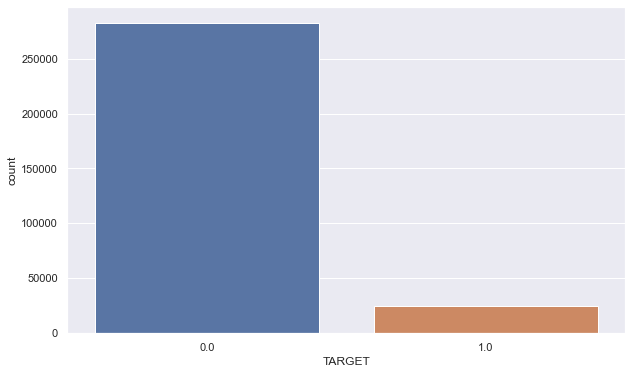

In [22]:
ax = sns.countplot(x='TARGET', data=train_df)
print(train_df['TARGET'].value_counts(normalize=True))

In [23]:
clf_lgbm.fit(X_train_std, Y_train)

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, num_leaves=34, reg_alpha=0.041545473,
               reg_lambda=0.0735294, subsample=0.8715623, verbose=-1)

In [24]:
#Y_valid_pred = clf.predict(X_valid_std)

In [25]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [26]:
# generate_model_report(Y_valid, Y_valid_pred)

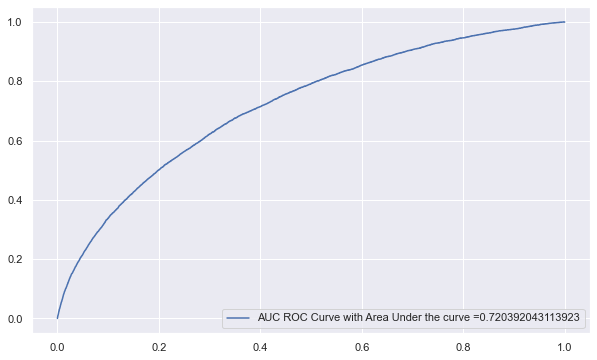

In [27]:
generate_auc_roc_curve(clf_lgbm, X_valid_std, Y_valid)

In [28]:
clf_lr.fit(X_train_std, Y_train)

LogisticRegression()

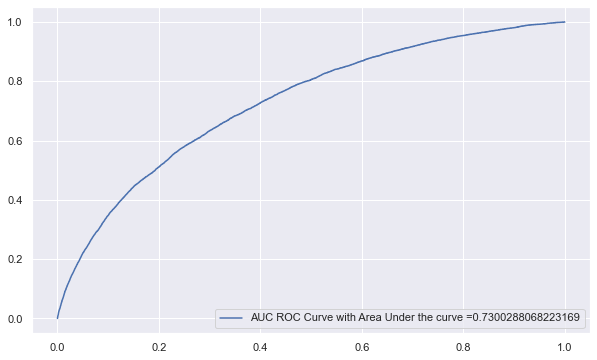

In [29]:
generate_auc_roc_curve(clf_lr, X_valid_std, Y_valid)

## Random undersampling

In [30]:
target = 'TARGET'
df = pd.DataFrame(X_train_std, columns=X_train.columns)
df[target] = Y_train
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

16655


In [31]:
majority_class_indices = df[df[target] == 0].index

In [32]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

16655


In [33]:
minority_class_indices = df[df[target] == 1].index

In [34]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [35]:
under_sample = df.loc[under_sample_indices]

In [36]:
under_sample[target].value_counts()

1.0    16655
0.0    16655
Name: TARGET, dtype: int64

In [37]:
X_train_std_us = under_sample.loc[:, df.columns!=target]
Y_train_us = under_sample.loc[:, df.columns==target]

In [39]:
clf_lgbm_us = clf_lgbm.fit(X_train_std_us, Y_train_us)
#Y_valid_us_pred = clf_us.predict(X_valid_std)

In [38]:
# print("Validation:")
# pd.crosstab(Y_valid_us_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [40]:
# generate_model_report(Y_valid, Y_valid_us_pred)

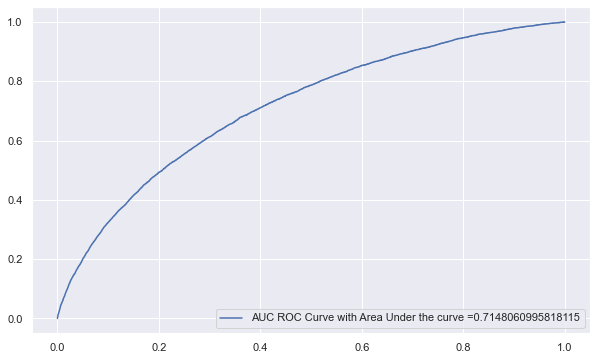

In [41]:
generate_auc_roc_curve(clf_lgbm_us, X_valid_std, Y_valid)

In [42]:
clf_lr_us = clf_lr.fit(X_train_std_us, Y_train_us)

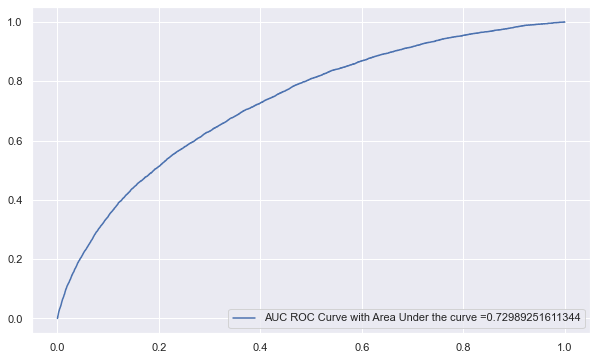

In [43]:
generate_auc_roc_curve(clf_lr_us, X_valid_std, Y_valid)

## Class_weight='balanced'

In [44]:
clf_lr_cw = LogisticRegression(class_weight='balanced').fit(X_train_std, Y_train)

In [45]:
clf_lgbm_cw = LGBMClassifier(
                        #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, 
                        class_weight='balanced').fit(X_train_std, Y_train)

In [58]:
from sklearn.utils import class_weight
class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)

array([0.54397383, 6.18519964])

In [46]:
# Y_valid_pred = clf_cw.predict(X_valid_std)

In [47]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [48]:
# generate_model_report(Y_valid, Y_valid_pred)

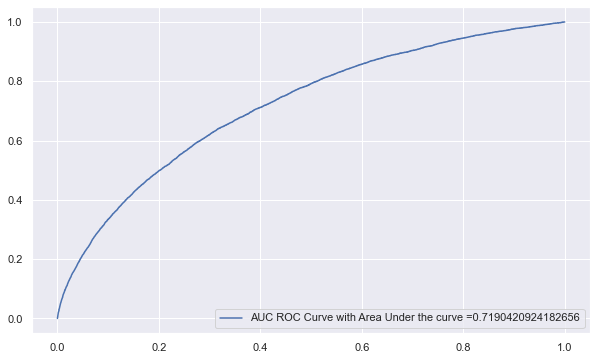

In [49]:
generate_auc_roc_curve(clf_lgbm_cw, X_valid_std, Y_valid)

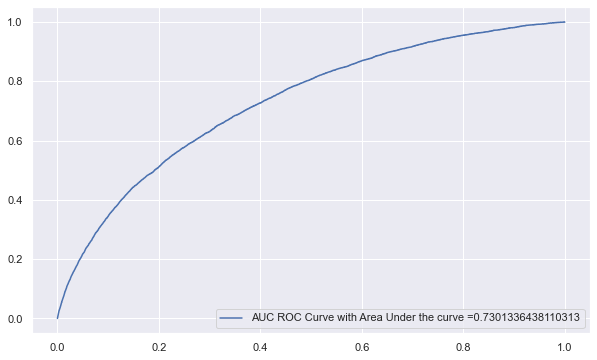

In [50]:
generate_auc_roc_curve(clf_lr_cw, X_valid_std, Y_valid)

In [60]:
# Define fbeta scorer with beta=3.16
scorer = make_scorer(fbeta_score, beta=3.16)

weights = np.linspace(0.05, 0.95, 10)
gsc = GridSearchCV(
    estimator=clf_lr,
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring=scorer,
    cv=3
)

grid_result = gsc.fit(X_train_std, Y_train)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}


<AxesSubplot:xlabel='weight'>

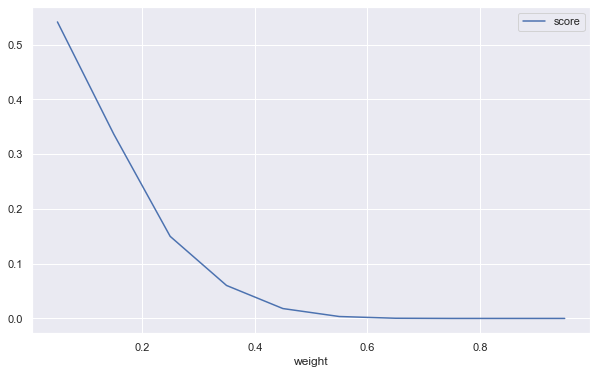

In [61]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [62]:
clf_lr_cw_gs = LogisticRegression(**grid_result.best_params_).fit(X_train_std, Y_train)

In [64]:
# Y_valid_pred = clf_lr_cw_gs.predict(X_valid_std)

In [65]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [66]:
# generate_model_report(Y_valid, Y_valid_pred)

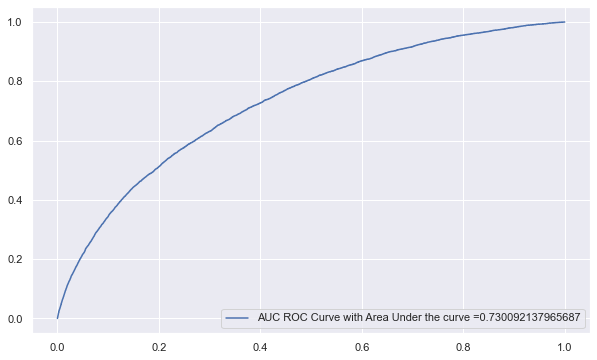

In [67]:
generate_auc_roc_curve(clf_lr_cw_gs, X_valid_std, Y_valid)

## SMOTE: Oversampling

In [68]:
unique, count = np.unique(Y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{0.0: 189374, 1.0: 16655}

In [69]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(X_train_std, Y_train)

In [70]:
pd.Series(y_train_res).value_counts()

0.0    189374
1.0    189374
dtype: int64

In [71]:
clf_lgbm_smote = clf_lgbm.fit(x_train_res, y_train_res)

In [72]:
# Y_valid_pred = clf_smote.predict(X_valid_std)

In [73]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [74]:
# generate_model_report(Y_valid, Y_valid_pred)

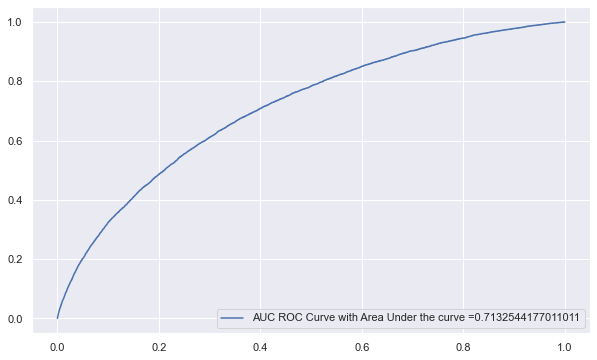

In [75]:
generate_auc_roc_curve(clf_lgbm_smote, X_valid_std, Y_valid)

In [76]:
clf_lr_smote = clf_lr.fit(x_train_res, y_train_res)

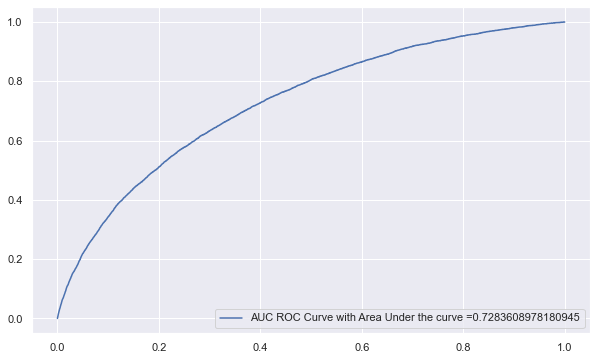

In [77]:
generate_auc_roc_curve(clf_lr_smote, X_valid_std, Y_valid)

In [78]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state = 2)
# clf.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

# Modélisation

Les modèles de classification à optimiser :

* **Random Forest** :  
    * (n_estimators) Le nombre d'arbres
    * (max_depth) La profondeur maximale de l'arbre
    * (criterions) La fonction pour mesurer la qualité d'un split. « gini » pour l'impureté de Gini et « entropie » pour le gain d'informations.
* **Lightgbm** :
    * (max_depth) : contrôle la distance maximale entre le nœud racine de chaque arbre et un nœud feuille. Diminuer max_depth réduit le temps d'entraînement.
    * (num_leaves): définit le nombre maximal de nœuds par arbre. Diminuer num_leaves réduit le temps de entraînement.

In [81]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("scoring")

2023/04/28 11:38:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/28 11:38:49 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///D:/Documents/0Openclasseroom/P7_DS_03_04_2023/Implementez_un_modele_de_scoring/mlruns/1', creation_time=1682674735258, experiment_id='1', last_update_time=1682674735258, lifecycle_stage='active', name='scoring', tags={}>

## Baseline: DummyClassifier

In [87]:
from sklearn.dummy import DummyClassifier

In [90]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='Dummy_baseline'):
    params = {
        "strategy": 'most_frequent',
    }
    
    mlflow.set_tag("model_name", "Dummy")
    mlflow.log_params(params)
    
    dc = DummyClassifier(strategy='most_frequent', 
                         random_state=14)

    dc.fit(X_train_std, Y_train)
    
    y_pred_proba = dc.predict_proba(X_valid_std)[:, 1]
    dc_auc = roc_auc_score(Y_valid, y_pred_proba)
    print(dc_auc)
    
    mlflow.log_metric('Valid_auc', dc_auc)
    mlflow.sklearn.log_model(dc, "sk_models")  

0.5


## RandomForestClassifier

In [85]:
from sklearn.ensemble import RandomForestClassifier
import logging

In [86]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='rf_baseline'):
    params = {
        "n_estimators": 100,
        "max_depth": 2
    }
    
    mlflow.set_tag("model_name", "RF")
    mlflow.log_params(params)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=2, class_weight='balanced')
    rf.fit(X_train_std, Y_train)
    
    y_pred_proba = rf.predict_proba(X_valid_std)[:, 1]
    rf_auc = roc_auc_score(Y_valid, y_pred_proba)
    print(rf_auc)
    
    mlflow.log_metric('Valid_auc', rf_auc)
    mlflow.sklearn.log_model(rf, "sk_models")     

0.7031540513698096


In [ ]:
# Dictionnaire de regresseurs
regressors_grid = {
    # modèles linéaires:    
               'Dummy': DummyRegressor(), #mean
               'Linear': LinearRegression(),
               'Ridge' : Ridge(),
               'Lasso' : Lasso(),
               'Elastic_Net' : ElasticNet(),
               'Linear_SVR' : LinearSVR(),
    # modèles non linéaires: 
               'KRR': KernelRidge(),
                'KNR': KNeighborsRegressor(),
    # modèles ensemblistes:          
               'Random Forest': RandomForestRegressor(),
               'Extra Tree': ExtraTreesRegressor(),
               'Gradient Boosting': GradientBoostingRegressor(),

            }
grid_params = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'alpha':np.logspace(-2, 2, 10)},#Ridge__alpha
                'Lasso'        : {'alpha':np.logspace(2, 8, 10)},
                'Elastic_Net'  : {'alpha': np.logspace(-10, 0, 10)},
                'Linear_SVR'   : {'epsilon' : np.logspace(-5, 5, 10), 
                                 'C' : np.logspace(0, 10, 10)},
                 'KRR'          : {'gamma' : np.logspace(-20, 0, 10) },
                 'KNR'          : {'n_neighbors': np.arange(2, 10, 2)},
                 'Random Forest': {'max_depth': [5, 10, 20, 30],
                                  'n_estimators': [100, 150, 200]},
                 'Extra Tree'    : {'n_estimators': [50,100,120],
                                  'criterion': ['mse', 'mae'],
                                   'max_depth': [4,8,10,12]},# 
               'Gradient Boosting': {'n_estimators':[10,50,100]},
              } 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result.iloc[:,:-2]